## RNN with frozen convolution layer. 

The idea is inspired by an application of RNN in predicting if an online review (say, for a product) is positive or negative (1 or 0). Each word in the review sentence is first projected to a large dimension vector space and then sent into an RNN network sequentially. 

We will make use of frozen convolution layer to create derivative like features for our time series features. Then, we use the derivative values of a certain time as if a "word" in a "review", the target RV as if the "score" of the "review" to train an RNN network that predicts the target RV with the time series features. 

## Example

In [69]:
import sys, importlib
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd

sys.path.append("../")
from proj_mod import training, data_processing
importlib.reload(training);
importlib.reload(data_processing);

Below is what Yuan needed to get his gpu working, do not run if you do not need it. 

In [3]:
from dotenv import load_dotenv
import os

load_dotenv("../dotenv_env/deep_learning.env")

True

In [4]:
print(os.environ.get("HSA_OVERRIDE_GFX_VERSION"))

10.3.0


Let's say, we have following timeseries feature (created randomly), we will create the derivative features first. As a reminder, the zero dimension is the batch size, the dimension one is channel (needed for the first convolution layer, not really a "thing" for time series like features). 

In [6]:
ts_feature=torch.randn(1,1,60)

In [8]:
ts_feature

tensor([[[-0.8983,  0.5294,  1.4815,  0.3880,  0.3053, -1.5859,  0.0210,
          -0.6448, -1.3457, -1.2188, -0.0443, -1.0198, -0.6600, -0.2874,
          -0.0385, -1.2630, -0.1093, -2.1785, -1.1292, -0.4585,  1.7239,
           0.9651,  0.1646, -0.7025,  0.6864,  1.0771, -0.9391,  0.5244,
           0.2303, -0.5098,  0.1424, -1.3571, -0.7195, -0.5237, -0.0643,
           0.4805, -0.4966, -0.7618,  0.3211,  0.0881, -1.3531, -1.1748,
          -2.0773, -0.4347,  0.3090,  0.9424,  0.8958,  1.6446,  1.7279,
           0.7207, -0.0487, -0.8066, -0.2446,  0.1778, -0.6278, -2.7156,
           0.2626,  1.2195, -0.9886, -1.0032]]])

In [7]:
conv_create_diff=training.frozen_diff_conv(n_diff=4)
ts_diff_feature=conv_create_diff(ts_feature)

In [9]:
ts_diff_feature

tensor([[[-8.9833e-01,  5.2935e-01,  1.4815e+00,  3.8805e-01,  3.0529e-01,
          -1.5859e+00,  2.1027e-02, -6.4484e-01, -1.3457e+00, -1.2188e+00,
          -4.4305e-02, -1.0198e+00, -6.5998e-01, -2.8743e-01, -3.8456e-02,
          -1.2630e+00, -1.0929e-01, -2.1785e+00, -1.1292e+00, -4.5855e-01,
           1.7239e+00,  9.6507e-01,  1.6458e-01, -7.0247e-01,  6.8645e-01,
           1.0771e+00, -9.3911e-01,  5.2441e-01,  2.3027e-01, -5.0984e-01,
           1.4243e-01, -1.3571e+00, -7.1949e-01, -5.2366e-01, -6.4339e-02,
           4.8050e-01, -4.9660e-01, -7.6183e-01,  3.2113e-01,  8.8130e-02,
          -1.3531e+00, -1.1748e+00, -2.0773e+00, -4.3466e-01,  3.0903e-01,
           9.4244e-01,  8.9581e-01,  1.6446e+00,  1.7279e+00,  7.2071e-01,
          -4.8721e-02, -8.0657e-01, -2.4458e-01,  1.7781e-01, -6.2775e-01,
          -2.7156e+00,  2.6262e-01,  1.2195e+00, -9.8861e-01, -1.0032e+00],
         [ 1.4277e+00,  9.5216e-01, -1.0935e+00, -8.2756e-02, -1.8912e+00,
           1.6069e+00, -

In [10]:
ts_diff_feature.shape

torch.Size([1, 5, 60])

We now permute the last two dimensions, essentially, this is just a transposition of the last two dimensions. 

In [14]:
ts_diff_feature=ts_diff_feature.permute(0,2,1)

In [15]:
ts_diff_feature.shape

torch.Size([1, 60, 5])

Now, this is a batch (of size 1) of timeseries feature with 60 time steps, and 5 features in each step. We then expand the 5 features, say, to 32 by projection. As a reminder, nn.Linear automatically apply to the last dimension. 

In [16]:
linear_proj=nn.Linear(5,32)
ts_feature_proj=linear_proj(ts_diff_feature)

In [17]:
ts_feature_proj.shape

torch.Size([1, 60, 32])

In this example, we will not go into too much detail, so let's make the most simple version. We then pass through a layer of RNN, then a layer of linear (to project to dimension 1 again). Learn more about RNN at https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html. 

In [36]:
RNN_layer=nn.RNN(input_size=32,hidden_size=32,num_layers=1,nonlinearity="tanh",batch_first=True,dropout=0)
linear_end=nn.Linear(32,1)

In [37]:
RNN_out=RNN_layer(ts_feature_proj)

As a reminder, since no training is done, the RNN basically just applies the initial weights. 

In [38]:
RNN_out[0].shape

torch.Size([1, 60, 32])

In [39]:
out_proj=linear_end(RNN_out[0])

In [41]:
out_proj.shape

torch.Size([1, 60, 1])

We will use sum, but we may change this to other functions, according to context or just feeling. 

In [44]:
sum_out=torch.sum(out_proj,dim=1)

In [46]:
sum_out

tensor([[-3.8542]], grad_fn=<SumBackward1>)

## Creating the actual NN 

In [ ]:
#Created 07/02/25
#07/02/25: Moved to training.py 
class RV_RNN_conv(nn.Module):
    """
    :param n_diff: Decides how many derivative features is wanted in the time series. 
    :param rnn_num_layer: num_layer parameter for rnn. 
    :param rnn_drop_out: dropout parameter for rnn. 
    :param rnn_act: Defaulted to "tanh". Nonlinearity parameter for rnn. 
    :param proj_dim: Defaulted to 32. Decided the dimension of projection before feeding into rnn. 
    :param rnn_hidden_size: Defaulted to 32. The hidden_size parameter for rnn. 
    """
    def __init__(self,n_diff,rnn_num_layer,rnn_drop_out,rnn_act="tanh",proj_dim=32,rnn_hidden_size=32):
        super().__init__()
        
        self.frozen_conv=training.frozen_diff_conv(n_diff=n_diff)
        self.linear_proj_input=nn.Linear(n_diff+1,proj_dim)
        self.RNN_layer=nn.RNN(input_size=proj_dim,hidden_size=rnn_hidden_size,num_layers=rnn_num_layer,nonlinearity=rnn_act,batch_first=True,dropout=rnn_drop_out)
        self.linear_post_rnn=nn.Linear(rnn_hidden_size,1)
        self.frozen_list=["frozen_conv"] 
        
    def forward(self,x):
        #First, unsqueese to add in one dimension in dim 1 as channel. This is needed for convolution. 
        x=torch.unsqueeze(x,dim=1)
        x=self.frozen_conv(x)
        x=x.permute(0,2,1)
        x=self.linear_proj_input(x)
        x=self.RNN_layer(x)[0]
        x=self.linear_post_rnn(x)
        
        return torch.sum(x,dim=1)

## Basic testing on the RNN with frozen convolution 

Test it first. As a reminder, the expected input dimensions are (Batch Size, Time Series Length), this is distinct from the example above in that the channel dimension is not present. The channel dimension is added with unsqueeze at dimension 1 so that the first convolution layer can be utilized. 

In [12]:
ts_feature=torch.randn(10,60)

In [14]:
ts_feature

tensor([[-7.0699e-01,  7.1855e-01,  1.0534e+00, -2.7195e-02, -5.3953e-01,
         -2.1916e-01,  2.6058e-01,  9.4682e-01, -5.7270e-01,  6.1821e-01,
          7.4706e-01,  8.5857e-01, -6.3387e-01,  1.0074e-01,  1.0871e+00,
          4.4188e-01,  6.0410e-01, -3.4202e-02, -1.5008e-01,  8.9701e-01,
         -6.9344e-01,  1.7957e+00, -5.8575e-01, -2.4478e+00,  7.0324e-01,
         -1.2766e+00, -3.7510e-01, -3.5719e-01, -1.3143e+00,  6.8766e-01,
         -2.5387e-01, -1.0662e+00,  5.9732e-01,  1.1774e+00,  1.7849e-01,
         -7.2704e-02, -6.2228e-01, -9.0305e-01, -7.6060e-01,  2.4960e+00,
         -3.7462e-01, -5.7164e-01,  7.3972e-02, -1.5861e+00, -7.6500e-01,
          8.6943e-01,  4.5075e-01,  1.3651e-02,  2.1515e-01, -1.4589e+00,
          1.1666e+00, -2.4947e-01, -6.6102e-01,  7.9651e-01,  7.1330e-01,
         -5.8549e-01,  8.9783e-01, -5.2981e-01, -1.6684e-01, -5.2264e-01],
        [ 6.6567e-01,  1.5717e-01, -8.9532e-01,  9.2971e-01, -6.0536e-01,
          5.8591e-02, -5.4184e-01,  3

In [15]:
torch.unsqueeze(ts_feature,dim=1)

tensor([[[-7.0699e-01,  7.1855e-01,  1.0534e+00, -2.7195e-02, -5.3953e-01,
          -2.1916e-01,  2.6058e-01,  9.4682e-01, -5.7270e-01,  6.1821e-01,
           7.4706e-01,  8.5857e-01, -6.3387e-01,  1.0074e-01,  1.0871e+00,
           4.4188e-01,  6.0410e-01, -3.4202e-02, -1.5008e-01,  8.9701e-01,
          -6.9344e-01,  1.7957e+00, -5.8575e-01, -2.4478e+00,  7.0324e-01,
          -1.2766e+00, -3.7510e-01, -3.5719e-01, -1.3143e+00,  6.8766e-01,
          -2.5387e-01, -1.0662e+00,  5.9732e-01,  1.1774e+00,  1.7849e-01,
          -7.2704e-02, -6.2228e-01, -9.0305e-01, -7.6060e-01,  2.4960e+00,
          -3.7462e-01, -5.7164e-01,  7.3972e-02, -1.5861e+00, -7.6500e-01,
           8.6943e-01,  4.5075e-01,  1.3651e-02,  2.1515e-01, -1.4589e+00,
           1.1666e+00, -2.4947e-01, -6.6102e-01,  7.9651e-01,  7.1330e-01,
          -5.8549e-01,  8.9783e-01, -5.2981e-01, -1.6684e-01, -5.2264e-01]],

        [[ 6.6567e-01,  1.5717e-01, -8.9532e-01,  9.2971e-01, -6.0536e-01,
           5.8591e-02,

In [16]:
model=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_num_layer=2,rnn_drop_out=0.3,rnn_hidden_size=32,proj_dim=32)

In [17]:
out=model(ts_feature)

In [18]:
out

tensor([[12.4432],
        [14.1024],
        [14.2141],
        [10.5330],
        [11.9638],
        [10.5465],
        [13.0989],
        [10.8659],
        [11.3673],
        [12.0642]], grad_fn=<SumBackward1>)

## Training loop (basic) 

In [5]:
list_time=np.load("../processed_data/recovered_time_id_order.npy")

In [6]:
time_split_list=data_processing.time_cross_val_split(list_time=list_time,n_split=1,percent_val_size=10,list_output=True)

In fold 0 :

Train set end at 8117 .

Test set start at 15516 end at 10890 .



In [7]:
train_time_id,test_time_id=time_split_list[0][0],time_split_list[0][1]

In [8]:
df_RV_ts=pd.read_parquet("../processed_data/book_RV_ts_60_si.parquet")

In [51]:
from sklearn.preprocessing import StandardScaler

In [52]:
scalar=StandardScaler()

In [54]:
df_RV_ts["sub_int_RV_norm"]=scalar.fit_transform(df_RV_ts[["sub_int_RV"]])

In [55]:
df_RV_ts

,time_id,sub_int_RV,sub_int_num,stock_id,row_id,sub_int_RV_norm
0,5,0.000015,1,0,0-5,-0.767245
1,11,0.000004,1,0,0-11,-0.787110
2,16,0.000432,1,0,0-16,-0.023625
3,31,0.000000,1,0,0-31,-0.793956
4,62,0.000235,1,0,0-62,-0.375815
...,...,...,...,...,...,...
25735915,6410,0.000000,60,99,99-6410,-0.793956
25735916,10421,0.000000,60,99,99-10421,-0.793956
25735917,25639,0.000000,60,99,99-25639,-0.793956
25735918,25680,0.000000,60,99,99-25680,-0.793956


In [9]:
df_RV_ts.pivot(index="row_id",columns=["sub_int_num"],values=["sub_int_RV"])

sub_int_RV                                                        \
sub_int_num         1         2         3         4         5             6    
row_id                                                                         
0-1000        0.000341  0.000000  0.000023  0.000000  0.000170  3.818799e-07   
0-10000       0.000290  0.000191  0.000087  0.000193  0.000241  3.154886e-04   
0-10005       0.000000  0.000000  0.001554  0.002177  0.002303  4.375100e-04   
0-10017       0.000142  0.000142  0.001464  0.001086  0.000068  6.771948e-05   
0-10030       0.000327  0.000058  0.000293  0.000842  0.000120  2.586782e-04   
...                ...       ...       ...       ...       ...           ...   
99-9972       0.000197  0.000181  0.000171  0.000172  0.000369  2.503467e-04   
99-9973       0.000821  0.000346  0.000691  0.001591  0.000863  9.650211e-04   
99-9976       0.000569  0.001101  0.001002  0.000430  0.000797  7.203531e-04   
99-9988       0.000040  0.000069  0.000123  0.000056  0.000016  1.957402e-04   
99-9993       0.000249  0.000179  0.000155  0.000025  0.000325  1.798617e-04   

                                                     ...                      \
sub_int_num        7         8         9         10  ...        51        52   
row_id                                               ...                       
0-1000       0.000089  0.000552  0.000012  0.000000  ...  0.000265  0.000000   
0-10000      0.000000  0.000247  0.000265  0.000000  ...  0.000202  0.000375   
0-10005      0.000617  0.001199  0.002306  0.001215  ...  0.000000  0.000486   
0-10017      0.000899  0.000064  0.000593  0.000451  ...  0.000029  0.000000   
0-10030      0.000221  0.000436  0.000099  0.000008  ...  0.000410  0.000437   
...               ...       ...       ...       ...  ...       ...       ...   
99-9972      0.000349  0.000356  0.000390  0.000050  ...  0.000075  0.000185   
99-9973      0.000504  0.001925  0.000641  0.000382  ...  0.001081  0.001095   
99-9976      0.000586  0.000538  0.000570  0.000781  ...  0.000508  0.000406   
99-9988      0.000071  0.000095  0.000063  0.000030  ...  0.000034  0.000176   
99-9993      0.000080  0.000125  0.000126  0.000205  ...  0.000099  0.000370   

                                                                   \
sub_int_num        53        54        55        56            57   
row_id                                                              
0-1000       0.000214  0.000003  0.000000  0.000118  2.313288e-04   
0-10000      0.000616  0.000564  0.000000  0.000023  3.777703e-08   
0-10005      0.000050  0.001761  0.001617  0.001801  2.552987e-03   
0-10017      0.001293  0.002092  0.000994  0.000848  3.104404e-03   
0-10030      0.000004  0.000215  0.000457  0.000183  4.842470e-04   
...               ...       ...       ...       ...           ...   
99-9972      0.000314  0.000318  0.000115  0.000143  9.916624e-05   
99-9973      0.000425  0.000789  0.001295  0.000596  1.862600e-03   
99-9976      0.000662  0.000338  0.000710  0.000179  5.946683e-04   
99-9988      0.000140  0.000129  0.000175  0.000019  1.440137e-04   
99-9993      0.000929  0.000328  0.000251  0.000204  2.728767e-04   

                                               
sub_int_num            58        59        60  
row_id                                         
0-1000       1.060893e-05  0.000111  0.000288  
0-10000      3.777703e-08  0.000020  0.000310  
0-10005      5.364106e-04  0.000872  0.000000  
0-10017      1.224910e-03  0.001316  0.003287  
0-10030      0.000000e+00  0.000756  0.000005  
...                   ...       ...       ...  
99-9972      1.809852e-04  0.000334  0.000089  
99-9973      7.668418e-04  0.001035  0.002115  
99-9976      1.509652e-04  0.000388  0.000403  
99-9988      3.200939e-05  0.000041  0.000007  
99-9993      2.108380e-04  0.000126  0.000353  

[428932 rows x 60 columns]

In [10]:
df_target=pd.read_csv("../raw_data/kaggle_ORVP/train.csv")

In [11]:
df_target["row_id"]=df_target["stock_id"].astype(int).astype(str)+"-"+df_target["time_id"].astype(int).astype(str)

In [12]:
df_target

,stock_id,time_id,target,row_id
0,0,5,0.004136,0-5
1,0,11,0.001445,0-11
2,0,16,0.002168,0-16
3,0,31,0.002195,0-31
4,0,62,0.001747,0-62
...,...,...,...,...
428927,126,32751,0.003461,126-32751
428928,126,32753,0.003113,126-32753
428929,126,32758,0.004070,126-32758
428930,126,32763,0.003357,126-32763


In [13]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV"],df_ts_feat=df_RV_ts,df_target=df_target)

/home/ycoeusz/git/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy.loc[:,"sub_int_num"]=np.nan
/home/ycoeusz/git/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy.loc[:,"sub_int_num"]=np.nan


In [14]:
train_dataset.features.shape

torch.Size([386036, 60])

In [15]:
train_dataset.target.shape

torch.Size([386036, 1])

Not entirely sure what the error code is about, I am literally doing exactly as suggested by the warning. https://stackoverflow.com/questions/23688307/settingwithcopywarning-even-when-using-loc says this is a false positive. 

## Training with native values, with a 10000 times scaler on input. 

A key issue with our input timeseries is that all values are extremely close to zero, so a 10000 times scaler can help with expanding them a little. 

In [16]:
device=(torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu"))
print(f"Using device {device}")

Using device cuda


In [38]:
RNN_model=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=10000).to(device=device)

In [39]:
import torch.optim as optim

optimizer=optim.Adam(RNN_model.parameters(),lr=1e-3)

In [40]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=256,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=256,shuffle=True)

In [41]:
train_loss=[]
val_loss=[]

In [42]:
training.reg_training_loop_rmspe(optimizer=optimizer,model=RNN_model,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=100,ot_steps=10,report_interval=5,eps=0,scaler=1)

At  9.23012661933899  epoch  1 has training loss  tensor(0.2709, device='cuda:0')  and validation loss  tensor(0.2373, device='cuda:0') .

At  48.45872116088867  epoch  5 has training loss  tensor(0.2545, device='cuda:0')  and validation loss  tensor(0.2368, device='cuda:0') .

At  96.10576176643372  epoch  10 has training loss  tensor(0.2532, device='cuda:0')  and validation loss  tensor(0.2348, device='cuda:0') .

At  144.24580764770508  epoch  15 has training loss  tensor(0.2527, device='cuda:0')  and validation loss  tensor(0.2345, device='cuda:0') .

At  191.81521773338318  epoch  20 has training loss  tensor(0.2519, device='cuda:0')  and validation loss  tensor(0.2376, device='cuda:0') .

At  238.4539635181427  epoch  25 has training loss  tensor(0.2517, device='cuda:0')  and validation loss  tensor(0.2395, device='cuda:0') .

At  285.9001407623291  epoch  30 has training loss  tensor(0.2513, device='cuda:0')  and validation loss  tensor(0.2341, device='cuda:0') .

At  333.981295

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[-1.0166e-02,  5.0208e-01,  2.3707e-01, -2.1755e-01, -8.7761e-02],
                      [ 2.3073e-02, -7.2817e-02, -4.2685e-01, -7.6756e-02,  1.9212e-01],
                      [-1.1001e-02, -6.2954e-02, -9.9150e-02, -8.2799e-02, -1.0407e-02],
                      [-2.3012e-01, -2.2045e-01, -3.8083e-01, -3.3201e-02,  4.8838e-02],
                      [ 4.0545e-01,  7.8722e-02, -2.1627e-01, -5.3211e-02, -1.9257e-01],
                      [ 1.8553e-02,  4.5463e-01,  4.1530e-01,  1.6941e-01, -1.2382e-03],
                      [ 1.9253e-02, -2.5209e-01, -1.8975e-01,  4.2143e-02, -5.0802e-02],
                      [ 1.6210e-02, -4.9789e-01, -3.6411e-01,  3.1163e-02,  1.0125e-01],
                      [-8.5251e-04,  2.5829e-01, -5.8556e-04, -2.2333e-01, -1.0621e-01],
                      [-5.3765e-01, -7.1270e-01, -2.6

In [49]:
for name,param in RNN_model.named_parameters():
    print(name,param.requires_grad)

frozen_conv.frozen_conv.weight False
linear_proj_input.weight True
linear_proj_input.bias True
RNN_layer.weight_ih_l0 True
RNN_layer.weight_hh_l0 True
RNN_layer.bias_ih_l0 True
RNN_layer.bias_hh_l0 True
linear_post_rnn.weight True
linear_post_rnn.bias True


In [43]:
len(train_loss)

49

In [44]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

Above is an example of the training. 

In [47]:
import matplotlib.pyplot as plt 

x=np.linspace(1,49,49)

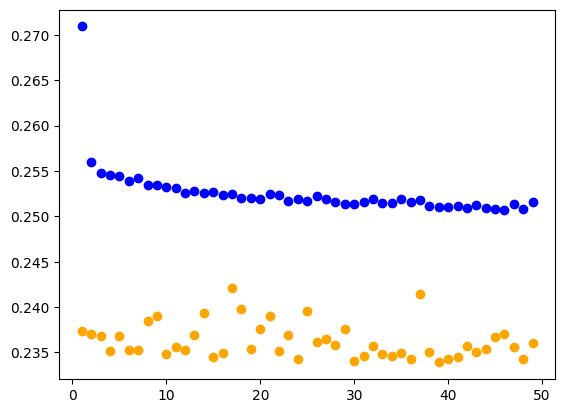

In [48]:
plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

## Try to normalize only the input. 

In [56]:
RNN_model_norm_ts=training.RV_RNN_conv(n_diff=4,rnn_act="tanh",rnn_drop_out=0,rnn_hidden_size=32,proj_dim=32,rnn_num_layer=1,input_scaler=1).to(device=device)

In [57]:
optimizer_norm_ts=optim.Adam(RNN_model_norm_ts.parameters(),lr=1e-3)

In [58]:
train_dataset=training.RVdataset(time_id_list=train_time_id,ts_features=["sub_int_RV_norm"],df_ts_feat=df_RV_ts,df_target=df_target)
test_dataset=training.RVdataset(time_id_list=test_time_id,ts_features=["sub_int_RV_norm"],df_ts_feat=df_RV_ts,df_target=df_target)

/home/ycoeusz/git/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy.loc[:,"sub_int_num"]=np.nan
/home/ycoeusz/git/Realized_Volatility_Prediction_-erdos_deeplearning-/NNetwork/../proj_mod/training.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tab_copy.loc[:,"sub_int_num"]=np.nan


In [59]:
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=256,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=256,shuffle=True)

In [60]:
train_loss=[]
val_loss=[]

In [62]:
training.reg_training_loop_rmspe(optimizer=optimizer_norm_ts,model=RNN_model_norm_ts,train_loader=train_loader,val_loader=test_loader,list_train_loss=train_loss,list_val_loss=val_loss,device=device,n_epochs=200,ot_steps=20,report_interval=5,eps=0,scaler=1)

At  9.253395318984985  epoch  1 has training loss  tensor(2.9448, device='cuda:0')  and validation loss  tensor(1.1058, device='cuda:0') .

At  48.75172233581543  epoch  5 has training loss  tensor(2.8769, device='cuda:0')  and validation loss  tensor(2.5862, device='cuda:0') .

At  97.71213459968567  epoch  10 has training loss  tensor(2.9242, device='cuda:0')  and validation loss  tensor(0.8594, device='cuda:0') .

At  147.71976971626282  epoch  15 has training loss  tensor(2.8378, device='cuda:0')  and validation loss  tensor(1.9252, device='cuda:0') .

At  196.09314608573914  epoch  20 has training loss  tensor(3.2858, device='cuda:0')  and validation loss  tensor(2.6849, device='cuda:0') .

At  245.30493760108948  epoch  25 has training loss  tensor(3.2313, device='cuda:0')  and validation loss  tensor(0.7104, device='cuda:0') .

The validation loss has not improved for  20  epochs. Stopping current training loop.

Best model state dictionary of this training loop is reloaded.

Ac

OrderedDict([('frozen_conv.frozen_conv.weight',
              tensor([[[-1.,  1.]]], device='cuda:0')),
             ('linear_proj_input.weight',
              tensor([[ 1.0828e-01, -3.5643e-04, -4.8510e-02,  9.2966e-02,  1.7199e-01],
                      [-1.3384e-04,  1.0969e-02,  2.6824e-01,  1.9068e-01,  3.3120e-03],
                      [-1.6602e-01, -2.0993e-01,  6.0612e-02, -2.7175e-01, -1.6795e-01],
                      [ 4.7048e-03, -5.7992e-02, -1.0478e-01, -8.5249e-02, -2.2236e-02],
                      [-8.8054e-02,  4.5599e-01,  2.2072e-01, -4.8502e-01, -2.7809e-01],
                      [ 1.0922e-01,  3.7854e-01, -4.7694e-02, -2.2077e-01, -1.8524e-01],
                      [ 1.0693e-03, -5.5686e-01, -4.1609e-01,  1.7900e-02,  9.7641e-02],
                      [ 1.9254e-03,  6.2266e-03, -1.6594e-01, -1.0216e-01,  3.2037e-03],
                      [-2.9815e-01, -6.7881e-02,  3.8021e-02,  5.3011e-02,  2.3592e-01],
                      [-1.4233e-01, -2.9872e-01,  5.9

As a remark, I ran above loop twice, the keep learning to same model after the fact. 

In [63]:
for name,param in RNN_model_norm_ts.named_parameters():
    print(name,param.requires_grad)

frozen_conv.frozen_conv.weight False
linear_proj_input.weight True
linear_proj_input.bias True
RNN_layer.weight_ih_l0 True
RNN_layer.weight_hh_l0 True
RNN_layer.bias_ih_l0 True
RNN_layer.bias_hh_l0 True
linear_post_rnn.weight True
linear_post_rnn.bias True


In [64]:
train_loss=[x.cpu() for x in train_loss]
val_loss=[x.cpu() for x in val_loss]

In [66]:
len(train_loss)

57

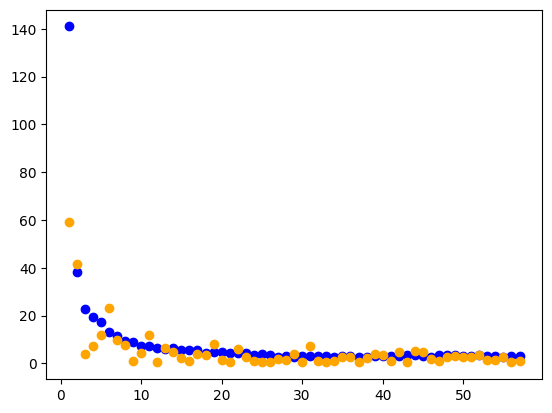

In [67]:
import matplotlib.pyplot as plt 

x=np.linspace(1,57,57)

plt.scatter(x,train_loss,c="blue")
plt.scatter(x,val_loss,c="orange")

It appears that only normalizing input ts is not a good idea. I should consider normalizing both the input and the target. Plus, in above, I fit transformed on both the training and the test set together, that is technically a data leak. 

## Training with normalization on both input and target 

I have added normalization functionality to dataset creation function, so not we can create the train and test datasets without dataleaking. 

I think setting eps to zero will still work, I do not see the possibility of a zero RV. Too tired today, will try tomorrow or something. 